### Milestone 4: Deep learning, due Wednesday, April 26, 2017

You can try different architectures, initializations, parameter settings, optimization methods, etc. Be adventurous and explore deep learning! It can be fun to combine the features learned by the deep learning model with a SVM, or incorporate meta data into your deep learning model. 

The notebook to submit this week should at least include:

- Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc. 
- Complete description of the pre-trained network that you fine tuned, including parameter settings, performance, features learned, etc. 
- Discussion of the results, how much improvement you gained with fine tuning, etc. 
- Discussion of at least one additional exploratory idea you pursued

In [40]:
import urllib2
import PIL
import os
import numpy as np
import math

# for image manipulation. Easier to do 
# here than with Keras, as per
# https://piazza.com/class/ivlbdd3nigy3um?cid=818
#!sudo pip install Image
import PIL.Image as Image
import pandas as pd
from sklearn.metrics import hamming_loss as sk_hamming_loss
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten

Using TensorFlow backend.


## Step One: Extracting Movies From URL 

In [3]:
train = pd.read_csv("train_full.csv")
train.drop("Unnamed: 0", axis=1, inplace=True)
print "Train shape:", train.shape
train.head(1)

Train shape: (7220, 32)


,10402,10749,10751,10752,10769,10770,12,14,16,18,...,lead actors,movie_id,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,0,0,0,0,0,0,0,0,0,1,...,"[u'Amy Adams', u'Jeremy Renner', u'Forest Whit...",329865,Taking place after alien crafts land around th...,25.66195,/hLudzvGfpi6JlwUnsNhXwKKg4j.jpg,2016-11-10,Arrival,False,6.9,3510


In [95]:
train_thinned = pd.read_csv("train.csv")
train_thinned.drop("Unnamed: 0", axis=1, inplace=True)
print "train_thinned shape:", train_thinned.shape
train_thinned.head(1)

train_thinned shape: (540, 29)


,10402,10749,10751,10752,12,14,16,18,27,28,...,lead actors,movie_id,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,0,0,1,0,0,0,1,0,0,0,...,"[u'Alec Baldwin', u'Miles Bakshi', u'Jimmy Kim...",295693,A story about how a new baby's arrival impacts...,305.881041,/unPB1iyEeTBcKiLg8W083rlViFH.jpg,2017-03-23,The Boss Baby,False,5.7,510


## Important. 

The line below aliases the DF that we want to work with as `curr_df`. When we decide later on to use the full training set instead of just `train_thinned`, all we need to do is set it in the cell below and re-run the code. This will prevent us from having to find/replace all instances of the past dataframe.

In [17]:
curr_df = train

# ensure all poster paths are strings
curr_df.poster_path = map(str, curr_df.poster_path)

In [161]:
## Helper that downloads web images 
## Takes in the poster path and the id of the movie 
## Saves the movie as a jpg as the unique id of the movie 
## In the images folder.
def download_web_image(poster_path, movie_id):
    # given that we're going to resize our images to be 32x32
    # or something else really small, let's download really small images 
    # to start
    base_url = "https://image.tmdb.org/t/p/w92/" 
    
    request = urllib2.Request(base_url + poster_path)
    img = urllib2.urlopen(request).read()
    image_name= "all_train_imgs/" + str(movie_id) + ".jpg"
    
    with open(image_name, 'w') as f: 
        f.write(img)

In [4]:
### iterate through all of the images in the thinned dataset, saving locally 
if 1:
    print "If you actually want to download posters, you'll need to turn the `1` above into a `0`. This code doesn't run by default in the notebook so that you don't accidentally download hundreds of images."
else:
    for index, row in curr_df.iterrows():
        if index % 200 == 0:
            print index
            
        movie_id = row["movie_id"]
        poster_path = row["poster_path"]
        
        try:
            download_web_image(poster_path, movie_id)
        except:
            continue

If you actually want to download posters, you'll need to turn the `1` above into a `0`. This code doesn't run by default in the notebook so that you don't accidentally download hundreds of images.


In [6]:
img_rows, img_cols = 32, 32

# convert each normal poster to a 32x32 grayscale poster
for img_name in os.listdir("all_train_imgs/"):
    ## This line added to avoid hidden files on mac (Stephen)
    if not img_name.startswith('.'):
        # read in an image and convert to greyscale
        im = Image.open("all_train_imgs/" + img_name).convert("L")
        out = im.resize((img_rows, img_cols))
        out.save("all_nn_ready_images/" + img_name)

# 1. Building a CNN from Scratch

In [8]:
epochs = 50
batch_size = 128

### Data Wrangling

In [9]:
# number of labels in our output
n_labels = 17

In [15]:
# now we need training and testing data. in the current state,
# we have a bunch of greyscale images named by their movie ids.
# to get the data, we can first just split all the movie ids (X) in the
# dataframe intro train and test sets, and then grab their multilabel
# matrices (y)
# m_ids = curr_df.movie_id.values

# gets all movie ids for which we have images
m_ids = map(int, map(lambda x: x[:-4], os.listdir("all_nn_ready_images")))

# shuffle the ids to get a random sample
np.random.shuffle(m_ids)
train_size = int(math.floor(.7 * len(m_ids)))

# get the movie_ids (each of which has an image in "nn_images_ready/"
# which is ready to be put through the neural net
train_ids = m_ids[:train_size]
test_ids = m_ids[train_size:]

In [18]:
# these are the column names of the multilabel matrix
label_names = curr_df.columns[:n_labels]

y_train = np.array([curr_df[curr_df.movie_id == movie_id][label_names].values[0] for movie_id in train_ids])
y_test  = np.array([curr_df[curr_df.movie_id == movie_id][label_names].values[0] for movie_id in test_ids])

# should be (num_samples, num_labels)
print "y_train shape:", y_train.shape
print "y_test shape:", y_test.shape

y_train shape: (1813, 17)
y_test shape: (778, 17)


In [19]:
# load image matrices into memory
x_train = np.array([np.asarray(Image.open("all_nn_ready_images/" + str(m_id) + ".jpg")) for m_id in train_ids])
x_test =  np.array([np.asarray(Image.open("all_nn_ready_images/" + str(m_id) + ".jpg")) for m_id in test_ids])

In [20]:
# output should be (num_images, img_height, img_width)
print "x_train shape:", x_train.shape
print "x_test shape:", x_test.shape

x_train shape: (1813, 32, 32)
x_test shape: (778, 32, 32)


In [21]:
# code borrowed from Keras_CNN lab

# now we need to reshape x_train and x_test so that they work with CNNs
# Following the example in "labs/Keras_CNN.ipynb", this needs to be an array 
# of images with shape determined by the backend, including the depth dimension,
# which is 1 for greyscale

# x_train is of shape n_samples x 32 x 32
# for a CNN we want to keep the image shape
# need to explicitly tell keras that it is a gray value image
# so each image is 32x32x1 not 32x32x3
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
# normalize image values to [0,1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print "x_train shape:", x_train.shape
print x_train.shape[0], "train samples"
print x_test.shape[0], "test samples"

x_train shape: (1813, 32, 32, 1)
1813 train samples
778 test samples


### Model Architecture

In [22]:
def build_cnn(n_layers, filters, kernels, a_func):
    """
    Wrapper function to create a CNN from scratch.
    
    We treat the number of layers, filter size, kernel size, and activation 
    function as parameters which can then be tuned.
    """
    # create an empty network model
    model = Sequential()
    
    for i in range(n_layers):
        # define the input layer to the CNN
        # input shape is a tuple of the # rows, # cols, and # channels (1 for grayscale)
        # the first parameter to Conv2D is the number of filters we want to convolve
        # over the input images
        model.add(Conv2D(filters[i], 
                         kernel_size=kernels[i], 
                         activation=a_func, 
                         input_shape=input_shape)
                 )

        # create a max pooling layer
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # flatten for fully connected classification layer
    model.add(Flatten())

    # --- fully connected layer ---
    model.add(Dense(64, activation='relu'))

    # recommended by: https://github.com/fchollet/keras/issues/761
    # uses a sigmoid activation rather than softmax, which apparently
    # gives us a label vector back
    model.add(Dense(n_labels, activation='sigmoid'))

    return model

In [34]:
def compile_cnn(model, loss="binary_crossentropy", lr=0.1, momentum=0.9):
    """
    Compiles a CNNs
    """
    # the setup is our basic categorical crossentropy with stochastic gradient decent
    # we also specify that we want to evaluate our model in terms of accuracy
    sgd = SGD(lr=0.1, momentum=0.9)

    # compile the model
    model.compile(loss=loss,
                  optimizer=sgd,
                  metrics=["accuracy"])

In [24]:
def train_cnn(model=None, x_train=None, y_train=None, x_test=None, y_test=None, batch_size=None, epochs=50):
    """
    Fit the CNN and score it against the test data
    
    Returns (history, score)
    """
    # this is now the actual training
    # in addition to the training data we provide validation data
    # this data is used to calculate the performance of the model over all the epochs
    # this is useful to determine when training should stop
    # in our case we just use it to monitor the evolution of the model over the training epochs
    # if we use the validation data to determine when to stop the training or which model to save, we 
    # should not use the test data, but a separate validation set. 
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        # this will use 30% of the train data as hold out
                        # for validation
                        validation_split=.3)

    # once training is complete, let's see how well we have done
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    return history, score

In [25]:
def plot_acc(model_history):
    plt.figure(figsize=(8, 6))

    max_train_acc = round(max(model_history.history['acc']), 2)
    max_test_acc = round(max(model_history.history['val_acc']), 2)

    plt.plot(model_history.history['acc'], 
             label="Train Acc (Max = {0})".format(max_train_acc))
    plt.plot(model_history.history['val_acc'], 
             label="Test Acc (Max = {0})".format(max_test_acc))

    plt.title("Model accuracy as a function of epochs")
    plt.xlabel("epoch")
    plt.legend(loc="lower right")
    plt.ylabel("accuracy")
    plt.show()

# Experimenting with Various CNNs (built from scratch)

In [29]:
# calculate the base rate
accuracy_list = [] 
for y in y_test: 
    for x in y:
        accuracy_list.append(x == 0)
    
print "This is our baseline accuracy", np.mean(accuracy_list)

This is our baseline accuracy 0.844321790413


In [26]:
# holds the history object and score object from each model we try
# out in case we want to make comparison plots later!
model_info = {}

# Model 1: 
* 1 convolution layer & 1 pool layer
* 8 filters applied to convolution layer
* Convolution kernels of size 3x3
* relU activation function

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1800)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                115264    
_________________________________________________________________
dense_2 (Dense)              (None, 17)                1105      
Total params: 116,449.0
Trainable params: 116,449.0
Non-trainable params: 0.0
_________________________________________________________________
('Test loss:', 0.38554743192802665)
('Test accuracy:', 0.83434146198331549)


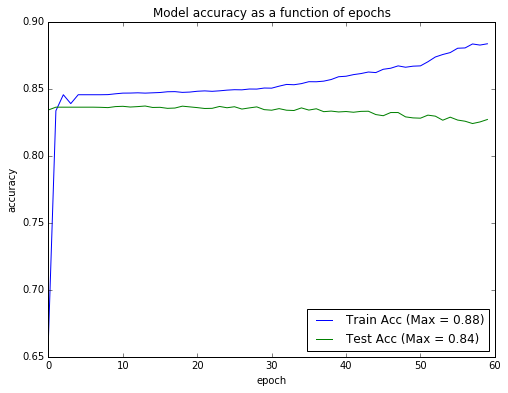

In [27]:
model = build_cnn(n_layers=1, 
                    filters=[8], 
                    kernels=[(3,3)], 
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train, 
                                           y_train=y_train,
                                           x_test=x_test,
                                           y_test=y_test, 
                                           batch_size=batch_size, 
                                           epochs=60)


model_info["model_1"] = {}
model_info["model_1"]["model_history"] = model_history
model_info["model_1"]["model_score"] = model_score

plot_acc(model_history)

We clearly start to overfit ar about epoch 50, at which point test accuracy dips because we're starting to model noise and training accuracy increases. At its best, out model is about 83% accurate on our test data.

# Model 2: 
* 3 convolution layers & 3 pool layers
* 8 filters applied to each convolution layer
* Convolution kernels of size 3x3
* relU activation function

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 8)         80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 8)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 8)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
__________

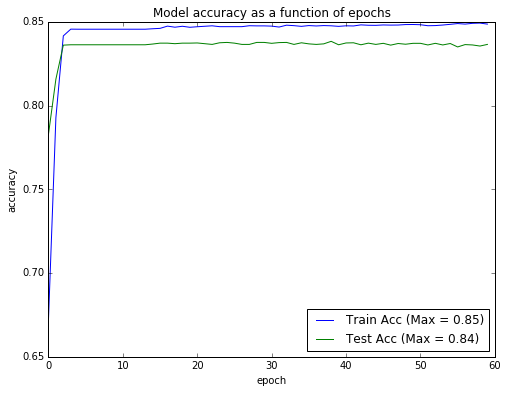

In [28]:
model = build_cnn(n_layers=3, 
                    filters=[8] * 3, 
                    kernels=[(3,3)] * 3, 
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train, 
                                           y_train=y_train,
                                           x_test=x_test,
                                           y_test=y_test, 
                                           batch_size=batch_size, 
                                           epochs=60)

model_info["model_2"] = {}
model_info["model_2"]["model_history"] = model_history
model_info["model_2"]["model_score"] = model_score

plot_acc(model_history)

While we're not overfitting in this more complicated model (i.e. more filters), we're failing to gain any more accuracy than in model 1, despite adding more layers!

# Model 3: 
* 4 convolution layers & 4 pool layers
* 32 filters applied to convolution layer
* Convolution kernels of size 2, 2
* relU activation function

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 31, 32)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 32)        4128      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 32)          4128      
__________

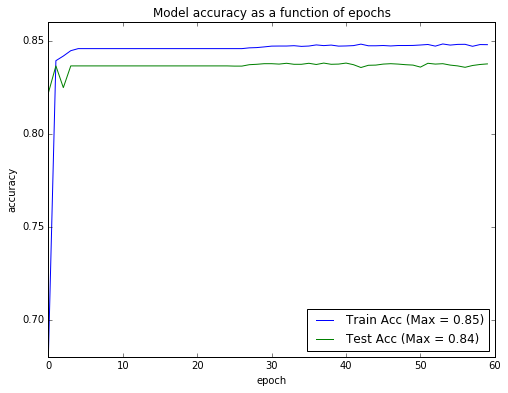

In [30]:
model = build_cnn(n_layers=4, 
                    filters=[32] * 4, 
                    kernels=[(2,2)] * 4, 
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train, 
                                           y_train=y_train,
                                           x_test=x_test,
                                           y_test=y_test, 
                                           batch_size=batch_size, 
                                           epochs=60)

model_info["model_3"] = {}
model_info["model_3"]["model_history"] = model_history
model_info["model_3"]["model_score"] = model_score

plot_acc(model_history)

Interesting! Even after using many more layers (4 convolution layers and 4 pool layers) as well as many more filters (32 per convolution layer), we're still maxing out at about 83% accuracy, which is also our baseline accuracy (e.g. exactly what we'd get if we applied a trivial classifier which guesses all 0s).

We can also try experimenting with the learning rate and momentum of the optimizer, which is SGD. Let's just try a different combination of values for model 3 to see if we get different results.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 31, 31, 32)        160       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 14, 14, 32)        4128      
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 2, 2, 32)          4128      
__________

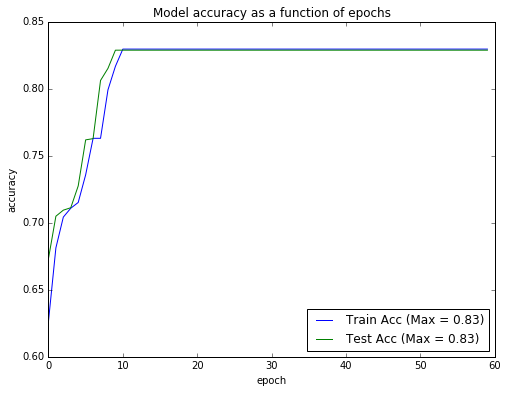

In [150]:
model = build_cnn(n_layers=4, 
                    filters=[32] * 4, 
                    kernels=[(2,2)] * 4, 
                    a_func='relu')

model.summary()
compile_cnn(model, lr=0.01, momentum=0.99)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train, 
                                           y_train=y_train,
                                           x_test=x_test,
                                           y_test=y_test, 
                                           batch_size=batch_size, 
                                           epochs=60)

model_info["model_3"] = {}
model_info["model_3"]["model_history"] = model_history
model_info["model_3"]["model_score"] = model_score

plot_acc(model_history)

Still getting the same accuracy as before (83%), even with a smaller learning rate.

In [151]:
[0,0,1].count(0)

2

# Tuning our CNN from Scratch

Per this quora answer: https://www.quora.com/How-can-I-decide-the-kernel-size-output-maps-and-layers-of-CNN

### On Kernels
- For kernel size, in general, smaller + deeper kernels are better
- Deeper networks are generally better (more layers), at the cost of more data required and increased learning complexity

### On batch
- batch size should be a few hundred

### On Filters
- initially should use fewer filters and gradually increase and monitor the error rate to see how it is varying
- very small filter sizes will capture very fine details of the image, bigger filters will leave out minute details in the image
- common kernel sizes are 3x3, 5x5, and 7x7

### Compile the model

Let's use a large learning rate (0.1) while we're working locally

In [112]:
# create an empty network model
model = Sequential()

# define the input layer to the CNN
# input shape is a tuple of the # rows, # cols, and # channels (1 for grayscale)
# the first parameter to Conv2D is the number of filters we want to convolve
# over the input images
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape))

# create a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add another convolution layer
# we could double the number of filters as max pool made the 
# feature maps much smaller, but we're not doing this to improve runtime
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))

# create a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# ================

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# create a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# ================

# flatten for fully connected classification layer
model.add(Flatten())

# note that the 10 is the number of classes we have
# the classes are mutually exclusive so softmax is a good choice
# --- fully connected layer ---
model.add(Dense(64, activation='relu'))

# recommended by: https://github.com/fchollet/keras/issues/761
# uses a sigmoid activation rather than softmax, which apparently
# gives us a label vector back
model.add(Dense(n_labels, activation='sigmoid'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 32)        4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 256)               0         
__________

In [113]:
# the setup is our basic categorical crossentropy with stochastic gradient decent
# we also specify that we want to evaluate our model in terms of accuracy
sgd = SGD(lr=0.01, momentum=0.9)

# TODO: why are we using binary crossentropy?
# I'm not sure, but it works much better than
# categorical crossentropy.
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

### Train the model

In [114]:
# this is now the actual training
# in addition to the training data we provide validation data
# this data is used to calculate the performance of the model over all the epochs
# this is useful to determine when training should stop
# in our case we just use it to monitor the evolution of the model over the training epochs
# if we use the validation data to determine when to stop the training or which model to save, we 
# should not use the test data, but a separate validation set. 
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=30,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 378 samples, validate on 162 samples
Epoch 1/30
378/378 [==============================] - 0s - loss: 0.6903 - acc: 0.5436 - val_loss: 0.6882 - val_acc: 0.5748
Epoch 2/30
378/378 [==============================] - 0s - loss: 0.6875 - acc: 0.6055 - val_loss: 0.6838 - val_acc: 0.6914
Epoch 3/30
378/378 [==============================] - 0s - loss: 0.6828 - acc: 0.7158 - val_loss: 0.6781 - val_acc: 0.7785
Epoch 4/30
378/378 [==============================] - 0s - loss: 0.6772 - acc: 0.7711 - val_loss: 0.6716 - val_acc: 0.7872
Epoch 5/30
378/378 [==============================] - 0s - loss: 0.6708 - acc: 0.7786 - val_loss: 0.6641 - val_acc: 0.7869
Epoch 6/30
378/378 [==============================] - 0s - loss: 0.6633 - acc: 0.7789 - val_loss: 0.6551

In [115]:
# once training is complete, let's see how well we have done
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 0.41369332722675656)
('Test accuracy:', 0.82897606160905624)


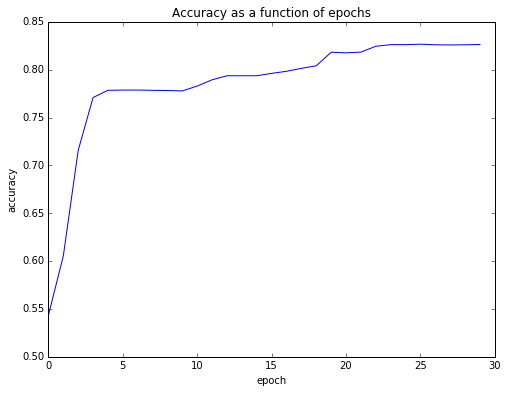

In [116]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.figure(figsize=(8, 6))
plt.plot(history.history['acc'])
plt.title("Accuracy as a function of epochs")
plt.xlabel("epoch")
plt.ylabel("accuracy")

('Test loss:', 0.35611025977563737)
('Test accuracy:', 0.84613639621930747)
Batch size: 32
Test loss: 0.356110259776
Test accuracy: 0.846136396219


('Test loss:', 0.35288712497235569)
('Test accuracy:', 0.84636323341673625)
Batch size: 64
Test loss: 0.352887124972
Test accuracy: 0.846363233417


('Test loss:', 0.35484603982045287)
('Test accuracy:', 0.84477543677646272)
Batch size: 128
Test loss: 0.35484603982
Test accuracy: 0.844775436776


('Test loss:', 0.35491416823588179)
('Test accuracy:', 0.84643883524333297)
Batch size: 256
Test loss: 0.354914168236
Test accuracy: 0.846438835243




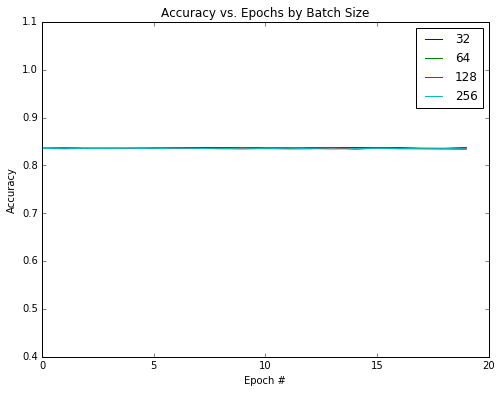

In [48]:
b_sizes = 2 ** np.arange(5, 9)

plt.figure(figsize=(8, 6))
plt.title("Accuracy vs. Epochs by Batch Size")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")

model = build_cnn(n_layers=4, 
                    filters=[32] * 4, 
                    kernels=[(2,2)] * 4, 
                    a_func='relu')

compile_cnn(model, loss="binary_crossentropy")

for b_size in b_sizes:
    
    model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train, 
                                           y_train=y_train,
                                           x_test=x_test,
                                           y_test=y_test, 
                                           batch_size=b_size, 
                                           epochs=20)

    print "Batch size:", b_size
    print "Test loss:", model_score[0]
    print "Test accuracy:", model_score[1]
    print "\n"
    
    plt.plot(model_history.history['val_acc'], label=str(b_size))

plt.legend(loc="best")
plt.ylim([.4, 1.1])
plt.show()

In [119]:
elts = []
for i in range(x_test.shape[0]):
    y_pred = map(lambda x: round(x, 0), model_1.predict(x_test[i].reshape(1, 32, 32, 1))[0])
    y_true = y_test[i]
    elts.append(np.mean(y_pred == y_true))

print np.mean(elts)

0.829339143065


# Exploratory Idea: Measuring the Effect of Different Loss Functions

At the time of this exploration, our models are predicting mostly 0s, giving us a high accuracy (83%), but one that is no better than a trivial classifier. Perhaps using binary crossentropy as our loss function is causing us to optimize this way. Though somewhat accurate, perhaps a different loss function would help us bump up our accuracy past the baseline. 

One loss function we should try is hamming loss, which is what we proposed using in the last milestone. Keras doesn't offer an out-of-the-box hamming loss function, but we can merely write our own and tell Keras to minimize it!

We'll test out different loss functions on a model with 4 convolution layers and 4 pool layers, using 32 filters per layer, each with kernels of size 2x2. 

In [35]:
loss_history = {}

In [37]:
model = build_cnn(n_layers=4, 
                    filters=[32] * 4, 
                    kernels=[(2,2)] * 4, 
                    a_func='relu')

('Test loss:', 0.3707700812265009)
('Test accuracy:', 0.84432179348634262)


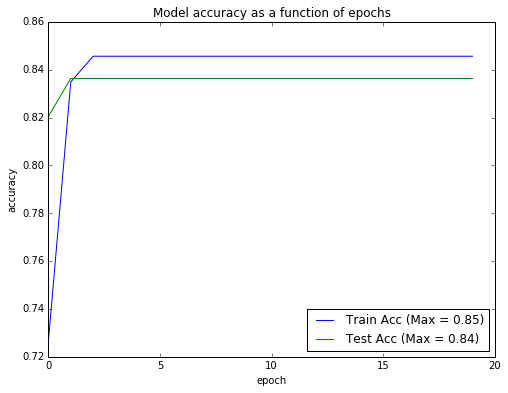

In [38]:
compile_cnn(model, loss="binary_crossentropy")

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train, 
                                           y_train=y_train,
                                           x_test=x_test,
                                           y_test=y_test, 
                                           batch_size=batch_size, 
                                           epochs=20)

plot_acc(model_history)

In [56]:
import tensorflow as tf
sess = tf.Session()

def hamming_loss(y_true, y_pred):
    y_true_val = sess.run(y_true)
    y_test_val = sess.run(y_pred)
        
#         return sk_hamming_loss(y_true_list, y_pred.eval())
    return 1

compile_cnn(model, loss=hamming_loss)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train, 
                                           y_train=y_train,
                                           x_test=x_test,
                                           y_test=y_test, 
                                           batch_size=batch_size, 
                                           epochs=20)

plot_acc(model_history)

InvalidArgumentError: You must feed a value for placeholder tensor 'dense_12_target_7' with dtype float
	 [[Node: dense_12_target_7 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op u'dense_12_target_7', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/ubuntu/.local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/ubuntu/.local/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/ubuntu/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-56-318c9a4f7d73>", line 11, in <module>
    compile_cnn(model, loss=hamming_loss)
  File "<ipython-input-34-d8f6a96c3c05>", line 12, in compile_cnn
    metrics=["accuracy"])
  File "/home/ubuntu/.local/lib/python2.7/site-packages/keras/models.py", line 766, in compile
    **kwargs)
  File "/home/ubuntu/.local/lib/python2.7/site-packages/keras/engine/training.py", line 878, in compile
    dtype=K.dtype(self.outputs[i]))
  File "/home/ubuntu/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 349, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/array_ops.py", line 1509, in placeholder
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 1997, in _placeholder
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'dense_12_target_7' with dtype float
	 [[Node: dense_12_target_7 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
